# Exploratory Data Analysis: Interest Rate Forecasting

## Objective

This notebook performs exploratory analysis on economic time series data to understand:
1. **Stationarity** - Which variables require differencing for modeling
2. **Temporal patterns** - Trends, seasonality, and structural breaks
3. **Relationships** - Granger causality between variables

## Key Findings

- **Treasury yields are non-stationary**: All yield series require first-order differencing
- **Macro indicators are stationary**: Sentiment, inflation expectations, and yield curve already stationary
- **Data period**: 1980-2023 (43 years), monthly frequency
- **Missing values**: Minimal after 1990, handled via forward-fill and interpolation

In [4]:
%load_ext autoreload
%autoreload 2

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from darts import TimeSeries
from darts.metrics import mape, r2_score, rmse
from darts.utils import statistics

import utils

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Data Loading and Overview

We load economic indicators from the FRED API including:
- **Target variable**: US 10-year Treasury yield
- **Covariates**: Fed funds rate, shorter-term yields, CPI, unemployment, S&P 500, GDP components, news sentiment

All data is resampled to monthly frequency and lagged appropriately to avoid look-ahead bias (e.g., CPI for month M is only known in month M+1).

In [5]:
# Load data from FRED API
df = utils.load_data()

print(f"Data shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nMissing values:\n{df.isnull().sum()[df.isnull().sum() > 0]}")

Data shape: (524, 24)
Date range: 1980-01-31 00:00:00 to 2023-08-31 00:00:00

Columns: ['FFED', 'US_PERSONAL_SPENDING_PCE', 'US_CPI', 'US_TB_YIELD_10YRS', 'US_TB_YIELD_1YR', 'US_TB_YIELD_2YRS', 'US_TB_YIELD_3YRS', 'US_TB_YIELD_5YRS', 'US_TB_YIELD_3MTHS', 'US_UNEMPLOYMENT_RATE', 'SNP_500', 'YIELD_CURVE', 'GDPC1', 'GPDI', 'W068RCQ027SBEA', 'TOTBKCR', 'STICKCPIM157SFRBATL', 'MICH', 'AWHMAN', 'EMRATIO', 'STDSL', 'EXPINF10YR', 'PAYEMS', 'NEWS_SENTIMENT']

Missing values:
US_PERSONAL_SPENDING_PCE    150
US_CPI                      150
US_TB_YIELD_3MTHS            20
US_UNEMPLOYMENT_RATE        150
SNP_500                     430
YIELD_CURVE                  20
EXPINF10YR                   24
NEWS_SENTIMENT               11
dtype: int64


/Users/Xavier/portfolio/cases/Forecasting Interest Rate Fluctuations/utils.py:354: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  autres = autres.apply(pd.to_numeric, errors="ignore")


## 2. Visual Exploration

Interactive visualization to explore raw time series and their first/seasonal differences.

**What to look for:**
- Trends (upward/downward slopes)
- Level shifts (structural breaks)
- Variance changes (heteroscedasticity)
- Seasonal patterns (repeating cycles)

In [ ]:
def plot_series(col, should_diff=False, diff_order=1):
    """Plot time series with optional differencing"""
    fig, ax = plt.subplots(figsize=(14, 5))
    
    if should_diff:
        series = df[col].diff(diff_order).dropna()
        title = f"{col} (Diff Order: {diff_order})"
    else:
        series = df[col]
        title = f"{col} (Raw)"
    
    series.plot(ax=ax, linewidth=1.5)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


interact(
    plot_series,
    col=widgets.Dropdown(options=df.columns, value="US_TB_YIELD_10YRS", description='Variable:'),
    should_diff=widgets.Checkbox(value=False, description='Apply Differencing'),
    diff_order=widgets.IntSlider(min=1, max=12, step=1, value=1, description='Diff Order:')
);

interactive(children=(Dropdown(description='Variable:', index=3, options=('FFED', 'US_PERSONAL_SPENDING_PCE', …

## 3. Stationarity Testing

### Why Test for Stationarity?

Most time series models (AR, VAR, LSTM) assume **stationarity**: constant mean, variance, and autocorrelation over time. Non-stationary series can lead to:
- Spurious correlations
- Invalid forecasts
- Poor model performance

### Augmented Dickey-Fuller (ADF) Test

- **Null hypothesis (H0)**: Series has a unit root (non-stationary)
- **Alternative (H1)**: Series is stationary
- **Decision rule**: Reject H0 if ADF statistic < critical value (typically 5% level)

We test three specifications:
- `n` (no trend, no constant): Pure random walk
- `c` (constant): Random walk with drift
- `ct` (constant + trend): Random walk with drift and deterministic trend

In [7]:
def run_adf_test(series, regression='ct', alpha=0.05):
    """
    Run ADF test and return results in structured format
    
    Args:
        series: pandas Series to test
        regression: 'n', 'c', or 'ct' (no trend, constant, constant+trend)
        alpha: Significance level (default 5%)
    
    Returns:
        dict with test results
    """
    series_clean = series.dropna()
    result = adfuller(series_clean, regression=regression)
    
    adf_stat = result[0]
    p_value = result[1]
    critical_value = result[4][f'{int(alpha*100)}%']
    
    is_stationary = adf_stat < critical_value
    
    return {
        'adf_statistic': adf_stat,
        'p_value': p_value,
        'critical_value_5pct': critical_value,
        'is_stationary': is_stationary
    }


# Test all variables with appropriate regression specifications
test_config = {
    # Treasury yields (expect non-stationary with trend)
    'US_TB_YIELD_10YRS': 'ct',
    'US_TB_YIELD_1YR': 'ct',
    'US_TB_YIELD_2YRS': 'ct',
    'US_TB_YIELD_3YRS': 'ct',
    'US_TB_YIELD_5YRS': 'ct',
    'US_TB_YIELD_3MTHS': 'ct',
    
    # Fed funds rate (policy-driven, expect non-stationary)
    'FFED': 'ct',
    
    # Inflation measures (trend-stationary or non-stationary)
    'US_PERSONAL_SPENDING_PCE': 'ct',
    'US_CPI': 'ct',
    
    # Equity index (trending)
    'SNP_500': 'ct',
    
    # Macro indicators (stationary around constant)
    'STICKCPIM157SFRBATL': 'c',  # Sticky CPI (% change already)
    'MICH': 'c',                 # Inflation expectations
    'AWHMAN': 'c',               # Avg weekly hours
    'STDSL': 'c',                # Small time deposits
    'EXPINF10YR': 'ct',          # Expected inflation 10yr
    'US_UNEMPLOYMENT_RATE': 'c',
    
    # Derived features (should be stationary)
    'NEWS_SENTIMENT': 'n',       # Already mean-zero
    'YIELD_CURVE': 'c',          # Spread
}

# Run tests
results = []
for var, regression in test_config.items():
    if var in df.columns:
        test_result = run_adf_test(df[var], regression=regression)
        results.append({
            'Variable': var,
            'Regression': regression,
            'ADF Statistic': f"{test_result['adf_statistic']:.3f}",
            'Critical Value (5%)': f"{test_result['critical_value_5pct']:.3f}",
            'p-value': f"{test_result['p_value']:.4f}",
            'Stationary?': '✓ Yes' if test_result['is_stationary'] else '✗ No'
        })

results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("STATIONARITY TEST RESULTS (ADF Test, α=0.05)")
print("="*80)
print(results_df.to_string(index=False))
print("\n" + "="*80)


STATIONARITY TEST RESULTS (ADF Test, α=0.05)
                Variable Regression ADF Statistic Critical Value (5%) p-value Stationary?
       US_TB_YIELD_10YRS         ct        -3.021              -3.419  0.1264        ✗ No
         US_TB_YIELD_1YR         ct        -3.554              -3.419  0.0340       ✓ Yes
        US_TB_YIELD_2YRS         ct        -3.175              -3.419  0.0895        ✗ No
        US_TB_YIELD_3YRS         ct        -2.993              -3.419  0.1339        ✗ No
        US_TB_YIELD_5YRS         ct        -2.912              -3.419  0.1584        ✗ No
       US_TB_YIELD_3MTHS         ct        -2.746              -3.419  0.2173        ✗ No
                    FFED         ct        -3.229              -3.419  0.0788        ✗ No
US_PERSONAL_SPENDING_PCE         ct        -1.446              -3.423  0.8470        ✗ No
                  US_CPI         ct         0.453              -3.422  0.9968        ✗ No
                 SNP_500         ct        -2.177     

### Interpretation

**Non-stationary variables (require differencing):**
- All Treasury yields (10Y, 5Y, 3Y, 2Y, 1Y, 3M)
- Federal funds rate
- Inflation indices (CPI, PCE)
- S&P 500 index

**Stationary variables (can use as-is):**
- News sentiment (already normalized)
- Yield curve spread (difference between yields)
- Inflation expectations and other macro % changes

**Modeling implication**: We'll apply first-order differencing to non-stationary series and use mixed preprocessing pipelines.

## 4. Data Preprocessing Pipeline

Based on stationarity results, we create three preprocessing pipelines:

1. **First-order differencing** (monthly): Treasury yields, Fed funds, CPI, PCE, unemployment
2. **Year-over-year differencing**: S&P 500, CPI (for seasonal adjustment)
3. **No differencing**: News sentiment, yield curve, inflation expectations

All pipelines include:
- Missing value imputation
- Standardization (zero mean, unit variance)

In [9]:
# Convert dataframe to TimeSeries objects with appropriate preprocessing
ts, covars_diff, covars_diff_yoy, covars_nodiff = utils.df2ts(df)

# Apply scaling pipelines
covars_diff_pipeline, covars_diff_scaled = utils.scale_ts(
    covars_diff, should_diff=True, diff_order=1
)
covars_nodiff_pipeline, covars_nodiff_scaled = utils.scale_ts(
    covars_nodiff, should_diff=False
)
covars_diff_yoy_pipeline, covars_diff_yoy_scaled = utils.scale_ts(
    covars_diff_yoy, should_diff=True, diff_order=12
)
pipeline, ts_scaled = utils.scale_ts(ts, should_diff=True, diff_order=1)

# Align all time series (ensure same time range)
covars_diff_scaled = covars_diff_scaled.slice_intersect(covars_diff_yoy_scaled)
covars_nodiff_scaled = covars_nodiff_scaled.slice_intersect(covars_diff_yoy_scaled)
ts_scaled = ts_scaled.slice_intersect(covars_diff_yoy_scaled)

# Stack all covariates into single multivariate series
covariates_scaled = covars_diff_scaled.stack(covars_nodiff_scaled).stack(covars_diff_yoy_scaled)

print(f"Target series: {ts_scaled.components}")
print(f"\nCovariates ({len(covariates_scaled.components)} total):")
print(f"  - Diff (1M): {list(covars_diff_scaled.components)}")
print(f"  - Diff (12M): {list(covars_diff_yoy_scaled.components)}")
print(f"  - No diff: {list(covars_nodiff_scaled.components)}")
print(f"\nFinal time range: {ts_scaled.start_time()} to {ts_scaled.end_time()}")
print(f"Sample size: {len(ts_scaled)} months")

Target series: Index(['US_TB_YIELD_10YRS'], dtype='object')

Covariates (23 total):
  - Diff (1M): ['FFED', 'US_TB_YIELD_1YR', 'US_TB_YIELD_2YRS', 'US_TB_YIELD_3YRS', 'US_TB_YIELD_5YRS', 'US_TB_YIELD_3MTHS', 'US_PERSONAL_SPENDING_PCE', 'EXPINF10YR', 'AWHMAN', 'STDSL', 'GDPC1', 'GPDI', 'W068RCQ027SBEA', 'TOTBKCR', 'US_UNEMPLOYMENT_RATE']
  - Diff (12M): ['SNP_500', 'US_CPI']
  - No diff: ['NEWS_SENTIMENT', 'YIELD_CURVE', 'STDSL', 'STICKCPIM157SFRBATL', 'MICH', 'EMRATIO']

Final time range: 1981-01-31 00:00:00 to 2023-08-31 00:00:00
Sample size: 512 months


## 5. Train/Validation Split

**Temporal split at 2016-01-01:**
- Training: 1980-2015 (36 years)
- Validation: 2016-2023 (7 years)

This split ensures:
- No look-ahead bias (strict chronological order)
- Recent data held out for evaluation
- Sufficient training data for deep learning models

Training set: 1980-01-31 00:00:00 to 2015-12-31 00:00:00 (432 months)
Validation set: 2016-01-31 00:00:00 to 2023-08-31 00:00:00 (92 months)


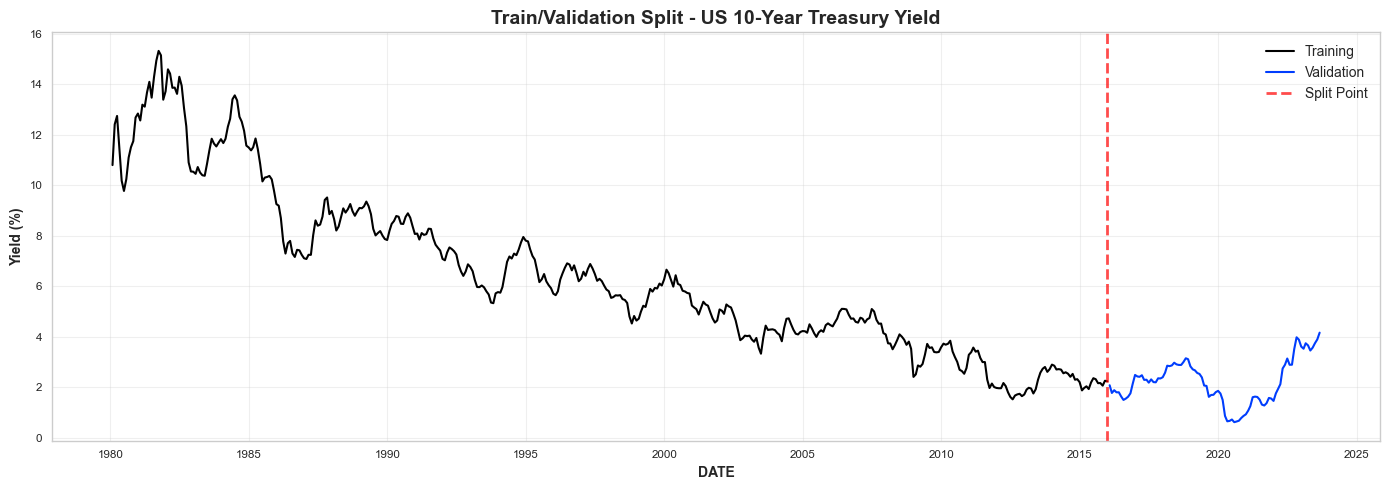

In [10]:
# Split at 2016
SPLIT_DATE = pd.Timestamp("2016-01-01")

train_ts, val_ts = ts.split_after(SPLIT_DATE)
train_ts_scaled, val_ts_scaled = ts_scaled.split_after(SPLIT_DATE)
train_covariates_scaled, val_covariates_scaled = covariates_scaled.split_after(SPLIT_DATE)

print(f"Training set: {train_ts.start_time()} to {train_ts.end_time()} ({len(train_ts)} months)")
print(f"Validation set: {val_ts.start_time()} to {val_ts.end_time()} ({len(val_ts)} months)")

# Visualize split
fig, ax = plt.subplots(figsize=(14, 5))
train_ts.plot(ax=ax, label='Training', linewidth=1.5)
val_ts.plot(ax=ax, label='Validation', linewidth=1.5)
ax.axvline(SPLIT_DATE, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Split Point')
ax.set_title('Train/Validation Split - US 10-Year Treasury Yield', fontsize=14, fontweight='bold')
ax.set_ylabel('Yield (%)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Granger Causality Test (Optional)

Test whether past values of the 10-year yield help predict future values (i.e., does the series "Granger-cause" itself).

**Interpretation:**
- High F-statistics → past values are predictive
- Low p-values → strong evidence of Granger causality

This helps validate autoregressive modeling approaches.

In [12]:
# Test if 10Y yield Granger-causes itself (validates AR modeling)
print("Testing whether past 10Y yields predict future 10Y yields...\n")
results = statistics.granger_causality_tests(ts_scaled, ts_scaled, maxlag=10)

Testing whether past 10Y yields predict future 10Y yields...


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=509, df_num=1
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=1
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=1
parameter F test:         F=43.5736 , p=0.0000  , df_denom=509, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=507, df_num=2
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=2
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=2
parameter F test:         F=28.8784 , p=0.0000  , df_denom=507, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=505, df_num=3
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=3
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=3
parameter F test:         F=20.6040 , p=0.0000  , df_denom=505, df_num=3

Granger Causality
number of lag

/Users/Xavier/portfolio/cases/Forecasting Interest Rate Fluctuations/.conda/lib/python3.12/site-packages/darts/utils/statistics.py:479: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
/Users/Xavier/portfolio/cases/Forecasting Interest Rate Fluctuations/.conda/lib/python3.12/site-packages/darts/utils/statistics.py:479: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
